# Modifications
We have seen how a simple pipeline works, data is retrieved at one end by the index given by the user, and then sequentially modified by the steps until it reaches it's final form.
```
index > step > step > output
```

However, with `edit.pipeline.modifications` this flow of data can be modified, (hence the name).

We could dynamically alter the index, cache data, and more

In [1]:
import edit.pipeline
import edit.data

In [2]:
edit.pipeline.modifications.__dir__()[8:]

['__builtins__',
 'idx_modification',
 'IdxModifier',
 'IdxOverride',
 'TimeIdxModifier',
 'SequenceRetrieval',
 'TemporalRetrieval',
 'cache',
 'Cache',
 'StaticCache',
 'MemCache',
 '__all__']

## Cache

These work by overriding how `Pipeline` retrieves it's initial sample. Each of these modifications knows about the steps above it and can therefore reconstruct it's 'parent' pipeline in which to retrieve data with. 

For example, when using the `Cache`, it will first check if data is already in the cache, and if not generate it and save it. It utilises the `edit.data.indexes.Cache` for this functionality, so utilises patterns to define the file structure.

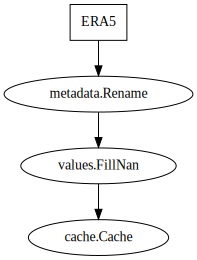

In [3]:
cached_pipeline = edit.pipeline.Pipeline(
    edit.data.archive.ERA5.sample(),
    edit.pipeline.operations.xarray.metadata.Rename({'2t':'2_metre_temperature'}),
    edit.pipeline.operations.xarray.values.FillNan(),
    edit.pipeline.modifications.Cache('temp'),
)
cached_pipeline

In [4]:
cached_pipeline.steps[-1]

Cache
	Initialisation                 An `edit.pipeline` implementation of the `CachingIndex` from `edit.data`.
		 cache      '/jobfs/122052107.gadi-pbs/...
		 cache_validity 'warn'                        
		 pattern    None                          
		 pattern_kwargs {}
		 save_kwargs None

Additionally, we can directly access the `edit.data.Cache` to check if data exists

In [5]:
cached_pipeline.steps[-1].cache

FunctionalCacheIndex
	Initialisation                 
		 function   <bound method Cache._genera...
		 pattern_kwargs {}
		 save_kwargs None                          
		 args       ('temp', None)                
	Transforms                     
		 StandardCoordinateNames {'latitude': "['lat', 'Latitude', 'yt_oce...", 'longitude': "['lon', 'Longitude', 'xt_oc...", 'replacement_dictionary': 'None                          ', 'time': "['Time']                      "}

It is worth pointing out that caches generate data upon any sort of lookup, so searching for them by definition, creates them, so we shall use the underlying pattern to actually check for existence.

In [6]:
cached_pipeline.steps[-1].pattern.exists('2000-01-01T00')

False

So, the data does not yet exist, but if we index into the pipeline it will be made

In [7]:
%%time
cached_pipeline['2000-01-01T00']

CPU times: user 1.44 s, sys: 573 ms, total: 2.01 s
Wall time: 7.4 s


<xarray.Dataset> Size: 8MB
Dimensions:              (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * longitude            (longitude) float32 6kB -180.0 -179.8 ... 179.5 179.8
  * latitude             (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2_metre_temperature  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

Now we can check if this data exists on disk

In [8]:
cached_pipeline.steps[-1].pattern.exists('2000-01-01T00')

True

Because the data is cached, it should now be a lot quicker to retrieve

In [9]:
%%time
cached_pipeline['2000-01-01T00']

CPU times: user 22.1 ms, sys: 6.39 ms, total: 28.5 ms
Wall time: 26.9 ms


<xarray.Dataset> Size: 8MB
Dimensions:              (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * longitude            (longitude) float32 6kB -180.0 -179.8 ... 179.5 179.8
  * latitude             (latitude) float32 3kB 90.0 89.75 89.5 ... -89.75 -90.0
  * time                 (time) datetime64[ns] 8B 2000-01-01
Data variables:
    2_metre_temperature  (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-30 21:47:55 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 2m_temperature 20000101-20000131

## Index Modifiers
In addition to the caches, Index Modifiers exists. They exist to alter the users data retrieved by modfiying the index.

The index can be:
- Replaced
- Added to
- Or temporally modified

Arguably, the most useful of these is the `SequenceRetrieval` and its subclass `TemporalRetrieval`,

In [10]:
edit.pipeline.modifications.SequenceRetrieval?

Init signature:
edit.pipeline.modifications.SequenceRetrieval(
    samples: 'Union[int, tuple[Union[tuple[int, ...], int], ...]]',
    *,
    merge_function: 'Optional[Callable]' = None,
    concat: 'bool' = False,
    merge_kwargs: 'Optional[dict[str, Any]]' = None,
)
Docstring:     
Subclassing from `IdxModifier`, retrieve a sequence of samples based on rules.

## Notes
Will attempt to stack samples, and may create a new 0 axis.

## Int

If `samples` is an `int`:
    Retrieve the idx originally asked for, and the sample offset by `samples`.
    This will return 'sorted'.
    >>> SequenceRetrieval(1)[0]
    # Will get (0, 1)
    >>> SequenceRetrieval(-1)[0]
    # Will get (-1, 0)
    >>> SequenceRetrieval(-6)[0]
    # Will get (-6, 0)

## Single element
If `samples` is a single element it must be of length 2 or 3, with the third being optional:
    Corresponds to a (offset, num_of_samples, Optional[interval, defaults to 1])

    The `idx` being requested is first offset, then num_of_s

The syntax for the arg of `samples` is as follows,

If a single int, 
- Index is modified and the original maintained, see `IdxModifier` for just a modification

If tuple,
- Offset, samples (optional, defaults 1), interval (optional, defaults 1)

Where offset modifies the index, samples defines how many to get, and interval defines the steps between samples

If nested tuple,
- Each tuple evaluated as above

Any data retrieved from a tuple specification will be automatically merged but returned if failed

In [19]:
index_mod = edit.pipeline.modifications.SequenceRetrieval(-3)

As we are using this independent of a pipeline, we need to override the `parent_pipeline` call

In [20]:
class override: 
    def __getitem__(self, idx): return idx

index_mod.parent_pipeline = override

In [21]:
index_mod[0]

(-3, 0)

In [24]:
index_mod = edit.pipeline.modifications.SequenceRetrieval((0,3,2))
index_mod.parent_pipeline = override
index_mod[0]

(0, 2, 4)

`TemporalRetrieval` takes this same concept and applies it to time indexes using `edit.data.EDITDatetime`